# Numerical Project in Python - Cooperative Kernel regression
## Ahmed Yassine Chraa - Emma de Charry - Pauline Zhou



## Part I - Class 1 & 2

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import dgd
import utils
from utils import *
from dgd_2 import *
from dual_decomposition import *
from admm2 import *

In [21]:
with open('first_database.pkl', 'rb') as f:
     x, y = pickle.load(f)
    
n, m, a = 100, 10, 5
sigma2 = 0.25
nu = 1
beta = 10
n_epochs = 100
sigma = 0.5

# Generate data
x_n = x[:n] 
y_n = y[:n]

sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = np.array([x[i] for i in ind])
Kmm = compute_kernel_matrix(x_selected, x_selected)
Knm = compute_kernel_matrix(x_n, x_selected)
alpha_star = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
#W = np.ones((a, a))
W = W(a)
K = compute_kernel_matrix(x_n, x_n)
selected_pts_agents = np.array_split(np.random.permutation(n), a)
step_size = 0.002

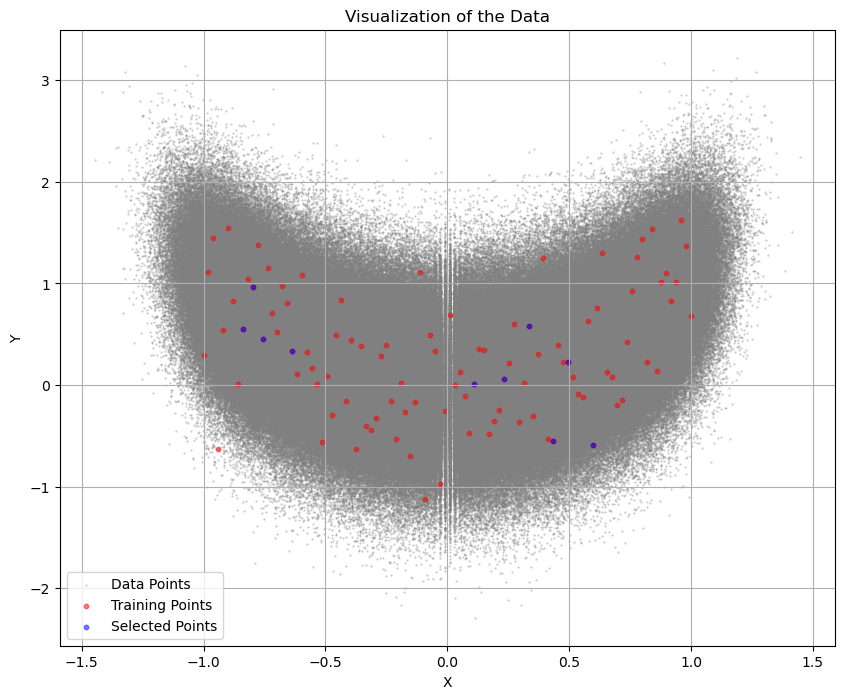

In [5]:
plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='gray',s=0.2, alpha=0.5, label='Data Points')
plt.scatter(x_n, y_n, color='red',s=10, alpha=0.5, label='Training Points')
plt.scatter(x_selected, [y[i] for i in ind], color='blue',s=10, alpha=0.5, label='Selected Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Visualization of the Data')
plt.legend()
plt.grid(True)
plt.show()

#### Useful functions that will be used along the notebook

 ### Decentralized gradient descent

 We are first going to define the DGD function and then apply it.

We then plot optimality gaps for each agent

Time to compute alpha optimal : 0.0002849102020263672

Optimal alpha : [ 1.13262943 -0.09806516 -0.59775697 -0.68482252  0.82571619  0.75961541
 -0.45796821 -0.21151104  0.05699831  0.15321202]

alpha optimal with DGD : [ 0.28760095 -0.01050057  0.01158806  0.0487695  -0.01446915 -0.01471186
  0.00091926  0.1361646   0.16978927 -0.01366488]
Time to compute alpha optimal with DGD : 8.976376056671143


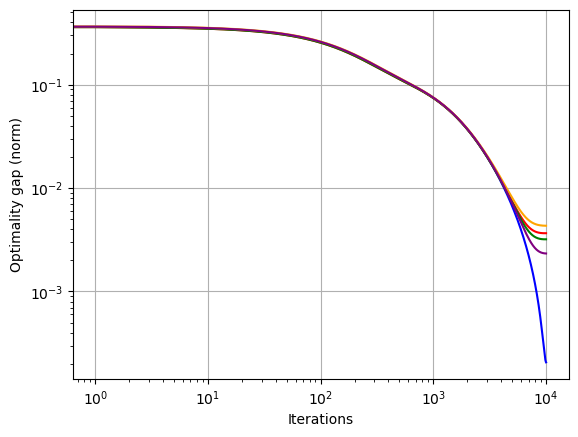

In [11]:
start = time.time()
alpha_optimal = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
end = time.time()
print(f'Time to compute alpha optimal : {end - start}\n')
print(f'Optimal alpha : {alpha_optimal}\n')
start = time.time()

opt_gaps, alpha_optim, alpha_list, alpha_mean_list = DGD(
    x_n, y_n, x_selected, a, nu, sigma2, alpha_optimal, W, step_size, n_epochs=10000)
end = time.time()
print(f'alpha optimal with DGD : {alpha_optim}')
print(
    f'Time to compute alpha optimal with DGD : {end - start}')
# print(f'Total iterations : {tot_ite}\n')

# Data visualization
Y = np.linalg.norm(alpha_list - alpha_optim, axis=1)
# unpack the list of alpha to get for each agent the evolution of alpha
agent_1 = np.linalg.norm(np.array(
    [alpha_list[i][0] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
agent_2 = np.linalg.norm(np.array(
    [alpha_list[i][1] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
agent_3 = np.linalg.norm(np.array(
    [alpha_list[i][2] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
agent_4 = np.linalg.norm(np.array(
    [alpha_list[i][3] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
agent_5 = np.linalg.norm(np.array(
    [alpha_list[i][4] for i in range(len(alpha_list))]) - alpha_optim, axis=1)

plt.plot(agent_1, label='Agent 1', color='blue')
plt.plot(agent_2, label='Agent 2', color='red')
plt.plot(agent_3, label='Agent 3', color='green')
plt.plot(agent_4, label='Agent 4', color='orange')
plt.plot(agent_5, label='Agent 5', color='purple')
plt.xlabel('Iterations')
plt.ylabel('Optimality gap (norm)')
plt.xscale("log")
plt.yscale("log")
#plt.savefig('opt_gaps_DGD_with_agents_scalelog.png', bbox_inches='tight')
plt.grid()
plt.show()

In [ ]:
###

In [12]:
nt = 250
x_prime=np.linspace(-1,1,nt)

### ADMM vs Dual Dec

Time to compute alpha optimal : 0.002198934555053711

Optimal alpha : [-0.01793711  0.14772265  0.5882162  -0.28708587  1.11110292  0.24515853
 -0.42994409  0.66593891 -0.49445345 -0.53284534]



100%|██████████| 10000/10000 [01:16<00:00, 130.83it/s]


alpha optimal with dual decomposition : [-0.00246827  0.11180788  0.30359355 -0.13285797  0.55252624  0.12865663
 -0.19908785  0.3438469  -0.21286353 -0.2371764 ]
Time to compute alpha optimal with dual decomposition : 76.5767149925232
alpha_optim shape: (5, 10)
alpha_list shape: (10001, 5, 10)


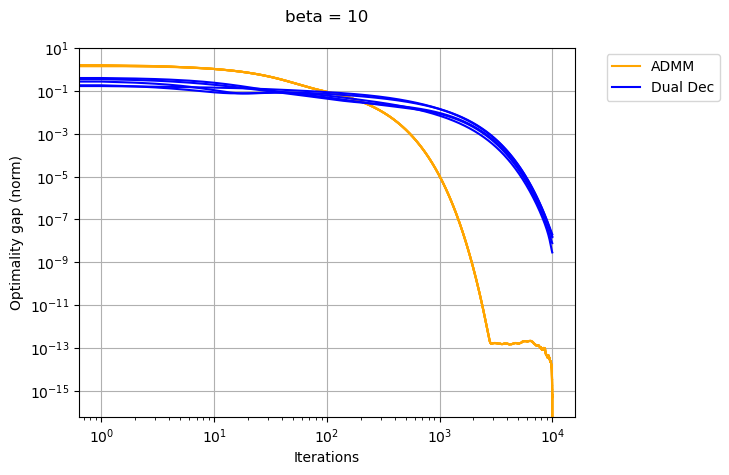

In [22]:
start = time.time()
alpha_optimal = compute_alpha_star(Kmm, Knm, y_n, sigma2, nu)
end = time.time()
print(f'Time to compute alpha optimal : {end - start}\n')
print(f'Optimal alpha : {alpha_optimal}\n')

#Execution de dual decomposition
start = time.time()
alpha_optim, alpha_list, alpha_mean_list = dualDec(
    x_n, y_n, x_selected, selected_pts_agents,
    K, sigma, nu, 0.1, W, max_iter=10000, lamb0=0.
)
end = time.time()
print(f'alpha optimal with dual decomposition : {alpha_optim}')
print(
    f'Time to compute alpha optimal with dual decomposition : {end - start}')


# Exécution d'ADMM
start = time.time()
alpha_optim_admm, alpha_list_admm, alpha_mean_list_admm, opt_gaps_admm = ADMM(x_n, y_n, x_selected, selected_pts_agents, a, nu, sigma2, 10000, W, K, beta)
admm_time = time.time() - start

# Vérification des dimensions
print(f"alpha_optim shape: {alpha_optim_admm.shape}")
print(f"alpha_list shape: {np.array(alpha_list_admm).shape}")
# Data visualization
Y = np.linalg.norm(alpha_list - alpha_optim, axis=1)
# Calcul des écarts de norme pour chaque agent dual dec
agent_1 = np.linalg.norm(np.array(
    [alpha_list[i][0] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
agent_2 = np.linalg.norm(np.array(
    [alpha_list[i][1] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
agent_3 = np.linalg.norm(np.array(
    [alpha_list[i][2] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
agent_4 = np.linalg.norm(np.array(
    [alpha_list[i][3] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
agent_5 = np.linalg.norm(np.array(
    [alpha_list[i][4] for i in range(len(alpha_list))]) - alpha_optim, axis=1)
# Calcul des écarts de norme pour chaque agent admm
agent_1_admm = np.linalg.norm(np.array([alpha_list_admm[i][0] for i in range(len(alpha_list_admm))]) - alpha_optim_admm[0], axis=1)
agent_2_admm = np.linalg.norm(np.array([alpha_list_admm[i][1] for i in range(len(alpha_list_admm))]) - alpha_optim_admm[1], axis=1)
agent_3_admm = np.linalg.norm(np.array([alpha_list_admm[i][2] for i in range(len(alpha_list_admm))]) - alpha_optim_admm[2], axis=1)
agent_4_admm = np.linalg.norm(np.array([alpha_list_admm[i][3] for i in range(len(alpha_list_admm))]) - alpha_optim_admm[3], axis=1)
agent_5_admm = np.linalg.norm(np.array([alpha_list_admm[i][4] for i in range(len(alpha_list_admm))]) - alpha_optim_admm[4], axis=1)

    # Tracé des résultats
plt.plot(agent_1_admm, label='ADMM', color='orange')
plt.plot(agent_2_admm, color='orange')
plt.plot(agent_3_admm, color='orange')
plt.plot(agent_4_admm, color='orange')
plt.plot(agent_5_admm, color='orange')
plt.plot(agent_1, label='Dual Dec', color='blue')
plt.plot(agent_2, color='blue')
plt.plot(agent_3, color='blue')
plt.plot(agent_4, color='blue')
plt.plot(agent_5, color='blue')
plt.xlabel('Iterations')
plt.ylabel('Optimality gap (norm)')
plt.xscale("log")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'beta = {beta}\n')
#plt.savefig('opt_gaps_dual_dec_vs_admm.png', bbox_inches='tight')
plt.grid()
plt.show()